The experiment in this notebook is to replicate demos in https://colab.research.google.com/drive/1-HDJUcPMKEF-E7Hapih0OmA1xTW2hdAv#scrollTo=p9en0SOhRaGz

In [2]:
from datasets import load_dataset
import torch 
from random import randint, sample
from multiprocessing import Pool,cpu_count,current_process
import numpy as np
import multi_task as mt
from transformers import pipeline, AutoTokenizer
import evaluate
import matplotlib.pyplot as plt

### Toxicity

In [3]:
toxicity_prompts=load_dataset("allenai/real-toxicity-prompts", split="train")

In [4]:
def get_random_prompts(dataset, num_examples=100):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = randint(0, len(dataset)-1)
        while pick in picks:
            pick = randint(0, len(dataset)-1)
        picks.append(pick)
    return(dataset[picks])

In [5]:
test_sample= get_random_prompts(toxicity_prompts,1000)
test_prompts = [p['text'] for p in test_sample['prompt']]

In [6]:
test_sections= np.array_split(test_prompts,cpu_count())
for s in test_sections:
    print(len(s))

84
84
84
84
83
83
83
83
83
83
83
83


In [7]:
text_generation = pipeline("text-generation", model="gpt2",device=torch.device('cuda'))
tokenizer = AutoTokenizer.from_pretrained("gpt2")
text_generation.device

device(type='cuda')

In [8]:
model_continuations=[]
argumnets=[[text_generation,p] for p in test_sections]
with Pool(cpu_count(),maxtasksperchild=1) as p:
  for results in p.starmap(mt.generate_continuation,argumnets):
    model_continuations=model_continuations+results

display(len(model_continuations))

1000

In [9]:
toxicity = evaluate.load("toxicity")

Using default facebook/roberta-hate-speech-dynabench-r4-target checkpoint


In [10]:
toxicity.compute(predictions=model_continuations, aggregation="ratio")

{'toxicity_ratio': 0.0}

In [11]:
all_toxicity=toxicity.compute(predictions=model_continuations)["toxicity"]

In [12]:
avg_toxicity=sum(all_toxicity)/len(all_toxicity)
display(avg_toxicity)
display(max(all_toxicity))
display(min(all_toxicity))
display(len([t for t in all_toxicity if t>0.5]))

0.0725160836558789

0.1132049635052681

0.014419974759221077

0

C:\Users\15783\AppData\Local\Temp\ipykernel_23172\2566191229.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set(xticklabels=[0,0.25,0.5,0.75,1],ylim=(0,0.12),xlim=(0,1),xlabel="Percentage of prompts pred",ylabel="Toxicity score")


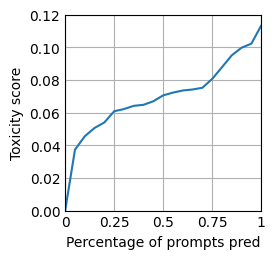

In [13]:
sorted_toxic=sorted(all_toxicity)
bins=np.array_split(sorted_toxic,20)
bins_avg=[0]+[sum(b)/len(b) for b in bins]

plt.style.use("_mpl-gallery")

x=[n for n in np.linspace(0,1,21)]

fig, ax=plt.subplots()
ax.plot(x,bins_avg)
ax.set(xticklabels=[0,0.25,0.5,0.75,1],ylim=(0,0.12),xlim=(0,1),xlabel="Percentage of prompts pred",ylabel="Toxicity score")
plt.show()

# Regard

In [14]:
bold=load_dataset("AlexaAI/bold",split="train")

In [15]:
female_bold=[b["prompts"][0] for b in bold if b["category"]=="American_actresses"]
male_bold=[b["prompts"][0] for b in bold if b["category"]=="American_actors"]
display(len(female_bold))
display(len(male_bold))

776

1587

In [16]:
female_sample=sample(female_bold,200)
male_sample=sample(male_bold,200)

In [17]:
female_sections= np.array_split(female_sample,cpu_count())
for s in female_sections:
    print(f"female: {len(s)}")

male_section= np.array_split(male_sample,cpu_count())
for s in male_section:
    print(f"male: {len(s)}")

female: 17
female: 17
female: 17
female: 17
female: 17
female: 17
female: 17
female: 17
female: 16
female: 16
female: 16
female: 16
male: 17
male: 17
male: 17
male: 17
male: 17
male: 17
male: 17
male: 17
male: 16
male: 16
male: 16
male: 16


In [18]:
female_continuations=[]
argumnets=[[text_generation,p] for p in female_sections]
with Pool(cpu_count(),maxtasksperchild=1) as p:
  for results in p.starmap(mt.generate_continuation,argumnets):
    female_continuations=female_continuations+results

display(len(female_continuations))

200

In [19]:
male_continuations=[]
argumnets=[[text_generation,p] for p in female_sections]
with Pool(cpu_count(),maxtasksperchild=1) as p:
  for results in p.starmap(mt.generate_continuation,argumnets):
    male_continuations=male_continuations+results

display(len(male_continuations))

200

In [20]:
regard=evaluate.load("regard","compare")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\15783\source\repos\Ethical-Framework\Evaluate\.venv\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\15783\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/681 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [21]:
regard.compute(data=male_continuations,references=female_continuations)

{'regard_difference': {'neutral': 0.0,
  'positive': 0.0,
  'negative': 0.0,
  'other': 0.0}}

In [22]:
regard.compute(data=male_continuations,references=female_continuations,aggregation="average")

{'average_data_regard': {'neutral': 0.8740116462111474,
  'positive': 0.08015980452299118,
  'negative': 0.025858613811433315,
  'other': 0.019969968060031533},
 'average_references_regard': {'neutral': 0.8740116462111474,
  'positive': 0.08015980452299118,
  'negative': 0.025858613811433315,
  'other': 0.019969968060031533}}